<a href="https://colab.research.google.com/github/ComponentSoftTeam/AI-110/blob/main/Deep_Learning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by code originally from Sinan Ozdemir's [notebook](https://github.com/sinanuozdemir/oreilly-pytorch-dl/blob/main/notebooks/1_mnist.ipynb).

## Setup

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Standardize random numbers for reproducibility
torch.manual_seed(0)
# Set grayscale as default
plt.gray()

<Figure size 640x480 with 0 Axes>

In [ ]:
def display_model_weights(model):
  fc1_weights = model.fc1.weight.data.cpu().numpy()
  fc2_weights = model.fc2.weight.data.cpu().numpy()

  # Visualize the weights of the first linear layer
  plt.figure(figsize=(10, 2))
  plt.imshow(fc1_weights, cmap='viridis', aspect='auto')
  plt.colorbar()
  plt.title('Weights of Linear Layer 1')
  plt.xlabel('Neuron Index')
  plt.ylabel('Input Dimension')
  plt.show()

  # Visualize the weights of the second linear layer
  plt.figure(figsize=(10, 2))
  plt.imshow(fc2_weights, cmap='viridis', aspect='auto')
  plt.colorbar()
  plt.title('Weights of Linear Layer 2')
  plt.xlabel('Neuron Index')
  plt.ylabel('Input Dimension')
  plt.show()

## Train

Label: 5


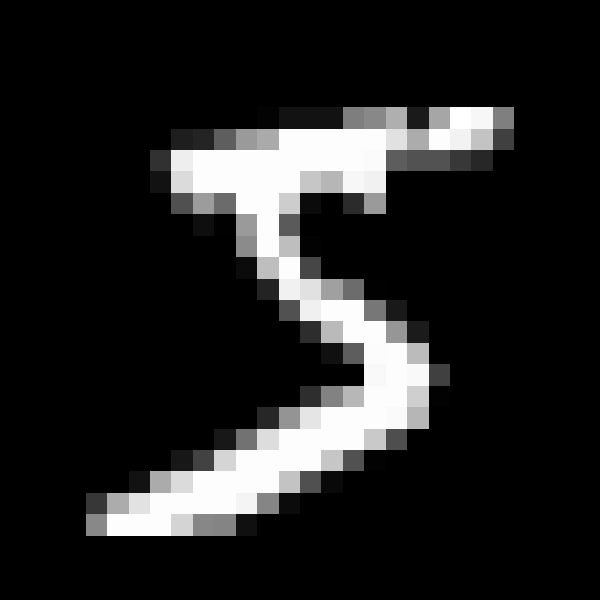

In [ ]:
import PIL
img, label = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]
# Resizing for illustration porposes, because the images are 28 x 28 each
img = img.resize((600, 600), resample=PIL.Image.Resampling.NEAREST)
print(f"Label: {label}")
img

In [ ]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10
batch_size = 100

In [ ]:
# train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
# means = [img.mean() for img, label in train_dataset]
# mean = sum(means) / len(means)
# sd = (sum([((img - mean)**2).sum() for img, label in train_dataset]) / (len(means) * 28 * 28))**0.5
# print((mean, sd))

(tensor(0.1307), tensor(0.3081))


In [ ]:
# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),                      # convert to pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,))  # standardize the values with mean + std
    ]
)

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create the model
model = NeuralNet(input_size, hidden_size, num_classes)

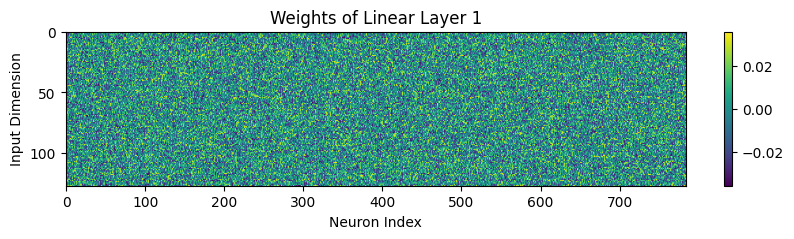

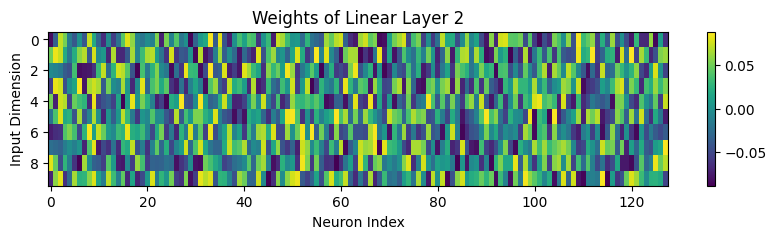

In [ ]:
display_model_weights(model)

In [ ]:
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0

        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):

            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()

            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [ ]:
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()

    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []

    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)

            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)

            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall


In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, nn.MultiMarginLoss(), train_loader, optimizer, num_epochs=5)
accuracy, f1, precision, recall = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Epoch [1/5], Loss: 0.0423
Epoch [2/5], Loss: 0.0154
Epoch [3/5], Loss: 0.0105
Epoch [4/5], Loss: 0.0079
Epoch [5/5], Loss: 0.0061
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9695, F1-score: 0.9693, Precision: 0.9692, Recall: 0.9696



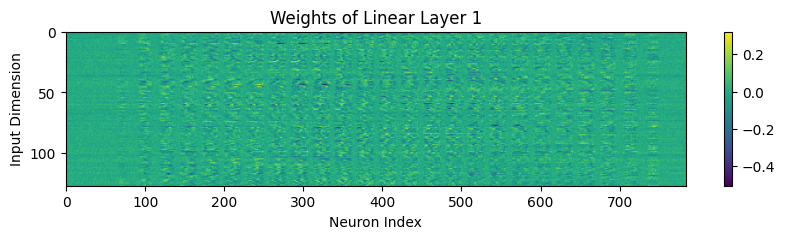

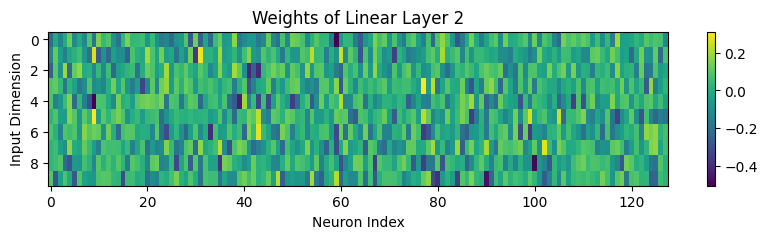

In [ ]:
display_model_weights(model)

# Inference

## Setup

In [ ]:
class IterativeRenderer:
  def __init__(self):
    self.chunk_size = 9
    self.current_chunk = -1
    self.imgs = None
    self.last_patch = None
    self.fig = None
    self.axis = None
    self.created = False

  def load_img_chunk(self, chunk_index):
    return [(np.squeeze(np.transpose(test_dataset[chunk_index * self.chunk_size + j][0], (1, 2, 0))), test_dataset[chunk_index * self.chunk_size + j][1]) for j in range(self.chunk_size)]

  def render_chunk(self, i):

    fig = plt.figure(figsize=(self.chunk_size*2.5, 3*2.5))
    gs = gridspec.GridSpec(2, self.chunk_size, height_ratios=[.5, 2], figure=fig)

    gs_subplots = gridspec.GridSpecFromSubplotSpec(1, self.chunk_size, subplot_spec=gs[:1, 0:-1])

    chunk_index = i // self.chunk_size
    i = i % self.chunk_size

    if self.last_patch:
      self.last_patch.remove()

    if chunk_index != self.current_chunk:
      imgs = self.load_img_chunk(chunk_index)
      chunk_index = self.current_chunk

      self.axis = []
      for j in range(self.chunk_size):
        ax = plt.subplot(gs_subplots[0, j], )
        self.axis.append(ax)

      for index in range(self.chunk_size):
        ax = self.axis[index]
        img, label = imgs[index]

        ax.imshow(img)
        ax.set_title(f'Label: {label}', fontsize=8)
        ax.axis('off')
        if i == index:
          x0, x1, y0, y1 = ax.axis()
          rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=6, edgecolor='cyan')
          self.last_patch = ax.add_patch(rec)
          self.last_patch.set_clip_on(False)

    else:
      ax = self.axis[i]

      x0, x1, y0, y1 = ax.axis()
      rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=6, edgecolor='cyan')
      self.last_patch = ax.add_patch(rec)
      self.last_patch.set_clip_on(False)

    ax2 = plt.subplot(gs[1:, :])
    img, label = imgs[i]
    ax2.imshow(img)
    ax2.set_title(f'Label: {label}', fontsize=14)
    ax2.axis('off')


    fig.tight_layout(pad = 2)
    plt.show()

iterative_renderer = IterativeRenderer()

In [ ]:
def display_prediction(i, width_limit = 160):
  iterative_renderer.render_chunk(i)
  test = test_dataset[i][0]
  test = test.reshape(-1, input_size)

  prediction = model(test)
  prediction = torch.nn.functional.softmax(prediction, dim=1)[0]

  print("")
  for i, val in enumerate(prediction.tolist()):
    print(f"{i}\t{val:.4%} {'#'*min(round(width_limit*val), width_limit)}")

  print(f"\nmax: \t{torch.max(prediction, 0)[1].item()}")

## Examples

In [ ]:
display_index = 0

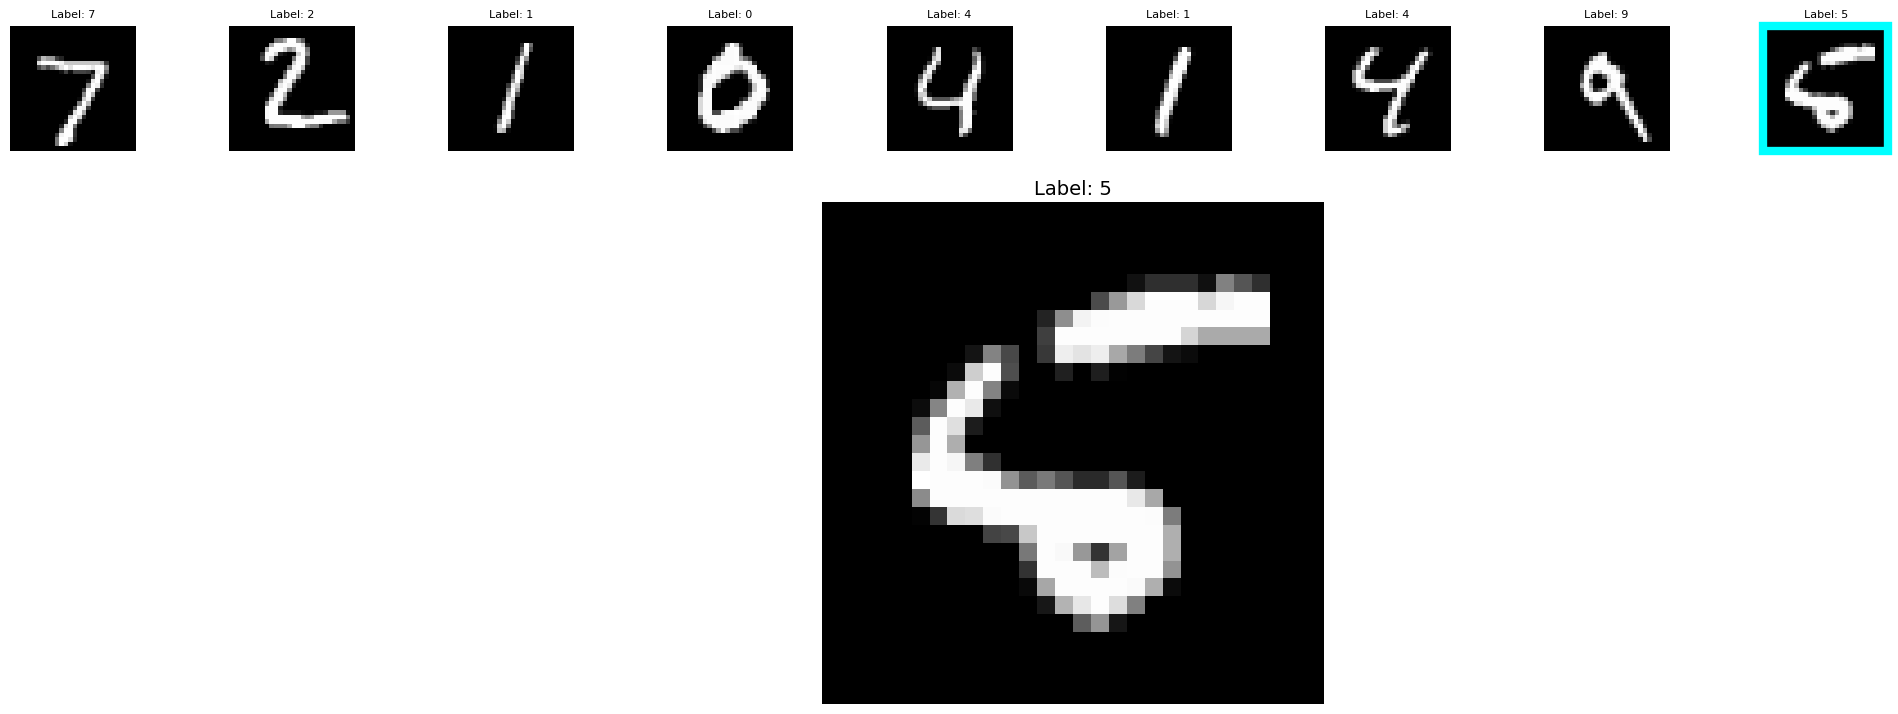


0	0.3396% #
1	0.0054% 
2	1.0172% ##
3	0.1322% 
4	1.4177% ##
5	29.9432% ################################################
6	65.3920% #########################################################################################################
7	0.0630% 
8	0.9134% #
9	0.7763% #

max: 	6


In [ ]:
display_prediction(display_index)
display_index += 1